In [273]:
import socket

import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re

data_csv = pd.read_csv('fr.openfoodfacts.org.products.csv', sep='\t')
# Afficher les noms de colonnes sous la forme d'une liste de chaînes de caractères


/tmp/ipykernel_38008/2317033117.py:10: DtypeWarning: Columns (0,3,5,24,25,26,27,28,35,36,37,38,39,48,65,67,70,71,72,78,79,80,83,84,85) have mixed types. Specify dtype option on import or set low_memory=False.
  data_csv = pd.read_csv('fr.openfoodfacts.org.products.csv', sep='\t')


In [274]:
# Liste des colonnes à conserver
variables_pertinentes = [
    'code', 'product_name', 'brands', 'categories', 'ingredients_text', 'additives_tags', 'nutrition_grade_fr',
    'nutrition-score-uk_100g',
    'energy_100g', 'proteins_100g', 'carbohydrates_100g', 'sugars_100g', 'fat_100g', 'saturated-fat_100g',
    'alcohol_100g', 'countries_fr'
]

start = time.time()
data = data_csv.drop([col for col in data_csv.columns if col not in variables_pertinentes], axis=1)
end = time.time()
print(f"Temps d'exécution de la méthode drop() : {end - start:.4f} secondes")


Temps d'exécution de la méthode drop() : 0.0200 secondes


<function show at 0x7fa689346950>


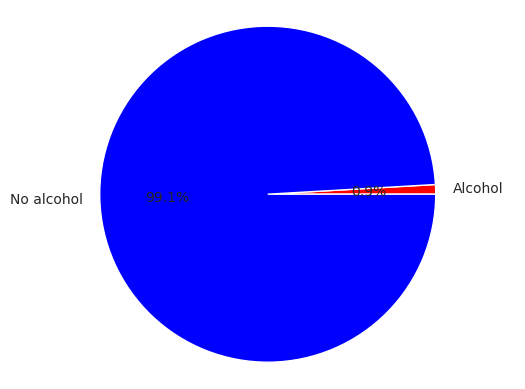

In [275]:
#Les produits contenant de l'alcool sont à bannir
#imputation par 0 des valeurs Null
data.loc[data['alcohol_100g'].isnull(), 'alcohol_100g'] = 0
data_alcohol = data[data['alcohol_100g'] > 0]
data_no_alcohol = data[data['alcohol_100g'] == 0]
percent_alcohol = len(data_alcohol) / len(data)
percent_no_alcohol = len(data_no_alcohol) / len(data)
labels = ['Alcohol', 'No alcohol']
sizes = [percent_alcohol, percent_no_alcohol]
colors = ['red', 'blue']
fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%')
ax.axis('equal')
print(plt.show)

<AxesSubplot: xlabel='Situation', ylabel='Count'>

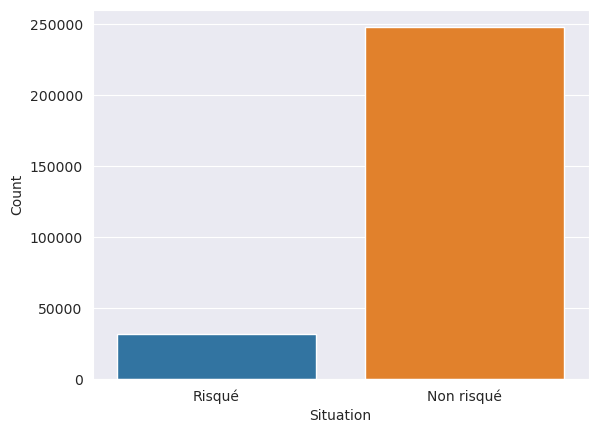

In [276]:
#les additifs
data.loc[data['additives_tags'].isnull(), 'additives_tags'] = ''
risky_additives = ['E250', 'E450', 'E202', 'E407', 'E252', 'E621', 'E224', 'E211', 'E482', 'E249', 'E212', 'E343',
                   'E1102', 'E511', 'E155']
risky_additives_regex = '|'.join(risky_additives)  # join the elements of the list with `|`
data['additives_tags_clean'] = data['additives_tags'].str.replace('en:', '')

# print(data.loc[40:55, 'additives_tags_clean'])
data['risky'] = 'non'
risky = data[data['additives_tags_clean'].str.contains(risky_additives_regex, case=False)]
data.loc[risky.index, 'risky'] = 'oui'

risky_count = len(data[data['risky'] == 'oui'])
non_risky_count = len(data[data['risky'] == 'non'])
# Créer un dataframe avec les données à afficher dans le graphique
risky_frame = pd.DataFrame({'Situation': ['Risqué', 'Non risqué'], 'Count': [risky_count, non_risky_count]})
sns.barplot(x='Situation', y='Count', data=risky_frame)




In [277]:
#retirer les aliments risqué
data.drop(data[data['risky'] == 'oui'].index, inplace=True)




In [278]:
indices_to_drop = data[data['alcohol_100g'] > 0].index
data = data.drop(indices_to_drop)

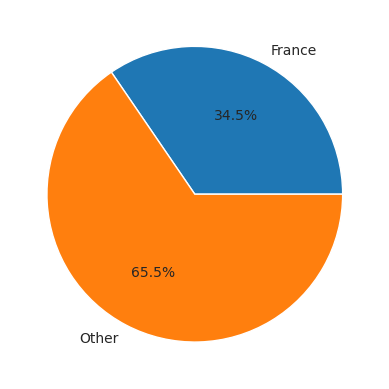

In [279]:
france_data = data[data['countries_fr'].str.contains('France', na=False)]
other_data = data[~data['countries_fr'].str.contains('France', na=False)]
france_percentage = len(france_data) / len(data) * 100
other_percentage = len(other_data) / len(data) * 100
plt.pie([france_percentage, other_percentage], labels=['France', 'Other'], autopct='%1.1f%%')
plt.show()



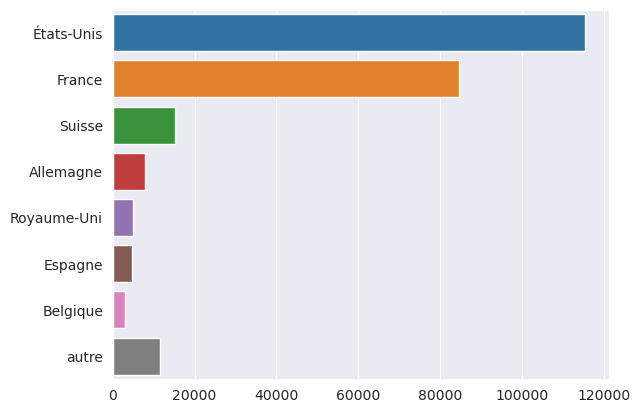

In [280]:
#répartition des produits par pays
pays = [
    "Afrique du Sud","Albanie","Algérie","Allemagne","Andorre","Angola","Arabie saoudite","Argentine","Arménie","Australie","Autriche","Azerbaïdjan",
    "Bahreïn","Bangladesh","Belgique","Belize","Bénin","Bhoutan","Biélorussie","Bolivie","Bosnie-Herzégovine","Botswana","Brésil","Brunei","Bulgarie","Burkina Faso","Burundi",
    "Cambodge","Cameroun","Canada","Cap-Vert","Chili","Chine","Chypre","Colombie","Comores","Congo","Corée du Nord","Corée du Sud","Costa Rica","Côte d'Ivoire","Croatie","Cuba",
    "Danemark","Djibouti","Dominique",
    "Égypte","Émirats arabes unis","Équateur","Érythrée","Espagne","Estonie","États-Unis","Éthiopie",
    "Fidji","Finlande","France",
    "Gabon","Gambie","Géorgie","Ghana","Grèce","Grenade","Guatemala","Guinée","Guinée-Bissau","Guinée équatoriale","Guyana",
    "Haïti","Honduras","Hong Kong","Hongrie",
    "Îles Marshall","Inde","Indonésie","Irak","Iran","Irlande","Islande","Israël","Italie",
    "Jamaïque","Japon","Jordanie",
    "Kazakhstan","Kenya","Kirghizistan","Kiribati","Koweït",
    "Laos","Lesotho","Lettonie","Liban","Liberia","Libye","Liechten","Liban","Lituanie","Luxembourg",
    "Malaisie","Malawi", "Mali", "Malte", "Maroc", "Maurice", "Mauritanie", "Mexique", "Moldavie", "Monaco","Mongolie", "Monténégro",
    "Nigeria", "Norvège", "Nouvelle-Calédonie", "Nouvelle-Zélande",
    "Oman",
    "Pays-Bas", "Pérou", "Philippines", "Pologne", "Portugal",
    "Qatar",
    "Roumanie", "Royaume-Uni", "République centrafricaine", "République dominicaine", "République tchèque",
    "Salvador", "Serbie", "Singapour", "Slovaquie", "Slovénie", "Suède",    "Suisse",
    "Taiwan", "Tanzanie", "Thaïlande", "Togo", "Tunisie", "Turquie",
    "Ukraine",
    "Venezuela", "Viêt Nam",
    "Yémen",
    "Zambie", "Zimbabwe"
]

data['countries_split'] = data['countries_fr'].str.split(',')
countries_series = data['countries_split'].explode().value_counts()
filtered_series = countries_series[countries_series.index.isin(pays)]

seuil = 3000
pays = filtered_series.loc[filtered_series >= seuil]
autre = pd.Series([filtered_series.loc[filtered_series < seuil].sum()], index=['autre'])
reordered_series =  pd.concat([pays, autre])

sns.barplot(x=reordered_series.values, y=reordered_series.index)
plt.show()





<AxesSubplot: xlabel='Situation', ylabel='Count'>

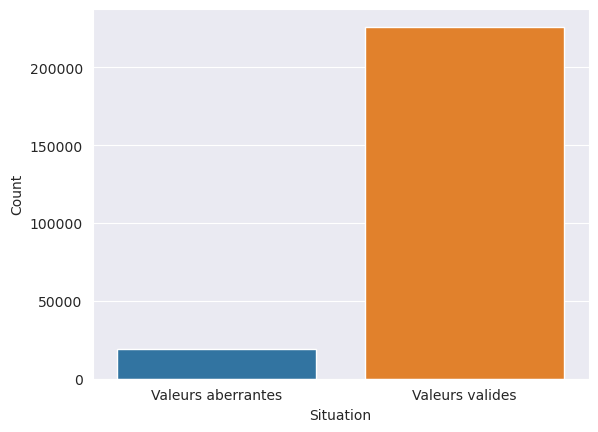

In [281]:
#enlever les valeurs non numériques aberrantes
list = ['fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'proteins_100g']
for v in list:
    data[v] = pd.to_numeric(data[v], errors='coerce')
    data.loc[data[v].isnull(), v] = 0
    data.loc[data[v] > 100, v] = 100

#les valeurs énergétiques sont aberrantes si les graisses saturées > aux graisses, si les sucres > carbohydrates et si la somme des carbohydrates, protéines et lipides dépassent 100g
aberrants = data[(data['saturated-fat_100g'] > data['fat_100g']) |
                 (data['sugars_100g'] > data['carbohydrates_100g']) |
                 (data['carbohydrates_100g'] + data['proteins_100g'] + data['fat_100g'] > 100)]

aberrants_count = len(aberrants)

aberrants_frame = pd.DataFrame(
    {'Situation': ['Valeurs aberrantes', 'Valeurs valides'], 'Count': [aberrants_count, len(data) - aberrants_count]})
sns.barplot(x='Situation', y='Count', data=aberrants_frame)


In [282]:
#suppression des valeurs aberrantes
data.drop(aberrants.index, inplace=True)
data

,code,product_name,brands,categories,countries_fr,ingredients_text,additives_tags,nutrition_grade_fr,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,proteins_100g,alcohol_100g,nutrition-score-uk_100g,additives_tags_clean,risky,countries_split
0,3087,Farine de blé noir,Ferme t'y R'nao,NaN,France,NaN,,NaN,NaN,0.00,0.00,0.00,0.00,0.00,0.0,NaN,,non,[France]
1,4530,Banana Chips Sweetened (Whole),NaN,NaN,États-Unis,"Bananas, vegetable oil (coconut oil, corn oil ...",,d,2243.0,28.57,28.57,64.29,14.29,3.57,0.0,14.0,,non,[États-Unis]
2,4559,Peanuts,Torn & Glasser,NaN,États-Unis,"Peanuts, wheat flour, sugar, rice flour, tapio...",,b,1941.0,17.86,0.00,60.71,17.86,17.86,0.0,0.0,,non,[États-Unis]
3,16087,Organic Salted Nut Mix,Grizzlies,NaN,États-Unis,"Organic hazelnuts, organic cashews, organic wa...",,d,2540.0,57.14,5.36,17.86,3.57,17.86,0.0,12.0,,non,[États-Unis]
4,16094,Organic Polenta,Bob's Red Mill,NaN,États-Unis,Organic polenta,,NaN,1552.0,1.43,0.00,77.14,0.00,8.57,0.0,NaN,,non,[États-Unis]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
279412,9948282780603,Tomato & ricotta,Panzani,NaN,Roumanie,NaN,,NaN,NaN,0.00,0.00,0.00,0.00,0.00,0.0,NaN,,non,[Roumanie]
279413,99567453,"Mint Melange Tea A Blend Of Peppermint, Lemon ...",Trader Joe's,NaN,États-Unis,"Organic peppermint, organic lemon grass, organ...",,b,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.0,,non,[États-Unis]
279414,9970229501521,乐吧泡菜味薯片,乐吧,Potato chips,Chine,NaN,,NaN,NaN,0.00,0.00,0.00,0.00,0.00,0.0,NaN,,non,[Chine]
279415,9980282863788,Tomates aux Vermicelles,Knorr,NaN,France,NaN,,NaN,NaN,0.00,0.00,0.00,0.00,0.00,0.0,NaN,,non,[France]
